In [38]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_PATH =  '../../../data/cluster/year/'
#os.listdir(DATA_PATH)

In [3]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [4]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.26%
Percent presence in y_valid: 13.92%
Percent presence in y_test: 12.64%


In [5]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [6]:
np.isfinite(X_valid).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
dtype: bool

In [7]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(526849, 24) (526849, 1)
(176146, 24) (176146, 1)
(175416, 24) (175416, 1)


In [8]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [9]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'elev_srtm30', 'year'], axis=1)
X_test  = X_test.drop(['studyArea',  'x', 'y', 'elev_srtm30', 'year'],  axis=1)

In [10]:
predictors = list(X_train)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'varPrecip_growingSeason', 'elev_etopo1', 'lat', 'lon']


In [11]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [12]:
y_train = y_train['beetle'].values.reshape(-1)
y_valid = y_valid['beetle'].values.reshape(-1)
y_test  = y_test['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [16]:
# Find optimal regularization via best validation-set accuracy
l1_mods = []
l2_mods = []
Cs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

t0 = time.time()
for C in Cs:
    print('Testing C =', C, end='; ')
    for penalty in ['l1', 'l2']:
        print('(%s)' % penalty, end=' ')
        logistic_clf = LogisticRegression(C=C, penalty=penalty)
        logistic_clf.fit(X_test, y_test)
        preds = logistic_clf.predict(X_valid)
        accuracy = sum(y_valid == preds) / len(preds)
        if penalty == 'l1':
            l1_mods.append(accuracy)
        else:
            l2_mods.append(accuracy)
        print('Elapsed time: %.2f minutes' % ((time.time() - t0) / 60))

Testing C = 0.0001; (l1) Elapsed time: 0.01 minutes
(l2) Elapsed time: 0.03 minutes
Testing C = 0.0005; (l1) Elapsed time: 0.05 minutes
(l2) Elapsed time: 0.06 minutes
Testing C = 0.001; (l1) Elapsed time: 0.11 minutes
(l2) Elapsed time: 0.13 minutes
Testing C = 0.005; (l1) Elapsed time: 0.34 minutes
(l2) Elapsed time: 0.36 minutes
Testing C = 0.01; (l1) Elapsed time: 0.49 minutes
(l2) Elapsed time: 0.52 minutes
Testing C = 0.05; (l1) Elapsed time: 0.73 minutes
(l2) Elapsed time: 0.76 minutes
Testing C = 0.1; (l1) Elapsed time: 1.02 minutes
(l2) Elapsed time: 1.05 minutes
Testing C = 0.5; (l1) Elapsed time: 1.37 minutes
(l2) Elapsed time: 1.40 minutes
Testing C = 1; (l1) Elapsed time: 1.63 minutes
(l2) Elapsed time: 1.66 minutes


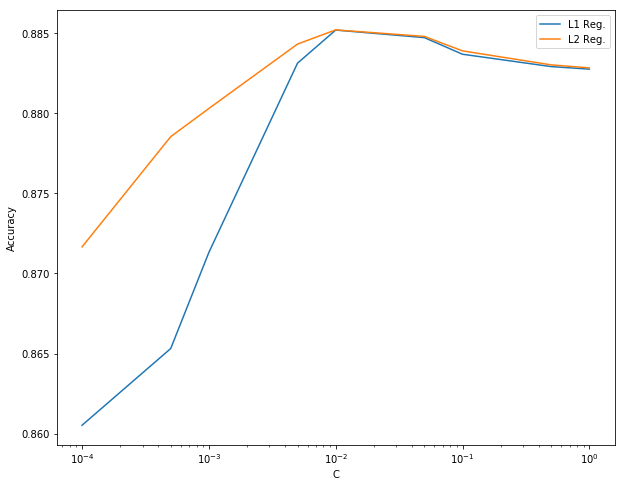

In [18]:
plt.plot(Cs, l1_mods, label='L1 Reg.');
plt.plot(Cs, l2_mods, label='L2 Reg.');
plt.xscale('log');
plt.xlabel('C');
plt.ylabel('Accuracy');
plt.legend(loc='best');

In [19]:
print(l1_mods)
print(l2_mods)

[0.86051911482520183, 0.86531059462037174, 0.87131697569062028, 0.88314239324196975, 0.88520886083135586, 0.88473766080410565, 0.88369874990065056, 0.8829266631090118, 0.88276770406367444]
[0.87166327932510534, 0.8785496122534715, 0.88030951596970697, 0.88433458608200011, 0.88522021504887993, 0.8848114632180123, 0.88390880292484642, 0.88303452817549077, 0.88284718358634318]


In [20]:
logistic_clf = LogisticRegression(C=0.01, penalty='l2')
logistic_clf.fit(X_train, y_train)
preds = logistic_clf.predict(X_test)
accuracy = sum(y_test == preds) / len(preds)
accuracy

0.87362042231039361

In [21]:
def get_predictions_at_threshold(pred_ps, threshold):
    return 1 * (pred_ps >= threshold)

def threshold_plot(pred_ps, targets):
    thresholds = np.linspace(0, 1, 500)
    accuracies = []
    n = len(pred_ps)

    for threshold in thresholds:
        preds = get_predictions_at_threshold(pred_ps, threshold)
        accuracies.append((preds == targets).sum() / n)
        
    plt.plot(thresholds, accuracies);
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_accuracy = max(accuracies)
    plt.plot([optimal_threshold, optimal_threshold], 
             [min(accuracies), max(accuracies)], 
             'r')
    plt.plot([0, 1], [optimal_accuracy, optimal_accuracy], 'r')
    plt.xlabel('Threshold for predicting "Renewal"')
    plt.ylabel('Accuracy')
    plt.show()
    return {'threshold': optimal_threshold, 'accuracy': optimal_accuracy}

[[ 0.99857065  0.00142935]
 [ 0.99867833  0.00132167]
 [ 0.9988732   0.0011268 ]
 [ 0.99707509  0.00292491]
 [ 0.99699636  0.00300364]]


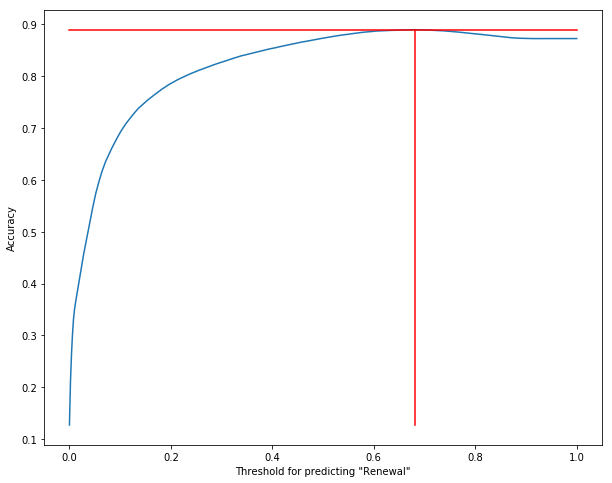

{'threshold': 0.68136272545090171, 'accuracy': 0.88991882154421487}


In [22]:
pred_ps = logistic_clf.predict_proba(X_test)
print(pred_ps[:5])
pred_ps = np.array([p[1] for p in pred_ps])
pred_ps[:5]

THRESHOLD = 0.5
preds = get_predictions_at_threshold(pred_ps, THRESHOLD)
preds[:5]

best_threshold = threshold_plot(pred_ps, y_test);
print(best_threshold)

In [23]:
preds = logistic_clf.predict(X_test)

In [24]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.5)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	12993		9321
        0	12848		140254
Accuracy:  0.87362042231
Precision: 0.502805618978
Recall:    0.582280182845
F1:        0.539632436922


In [25]:
cm = util.make_confusion_matrix(y_test, pred_ps, 0.681363)
metrics = util.get_metrics(cm)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	7226		15088
        0	4222		148880
Accuracy:  0.889918821544
Precision: 0.631201956674
Recall:    0.32383257148
F1:        0.428055209999


In [26]:
auc_metrics = util.get_auc(y_test, pred_ps)

AUC:       0.907664129213


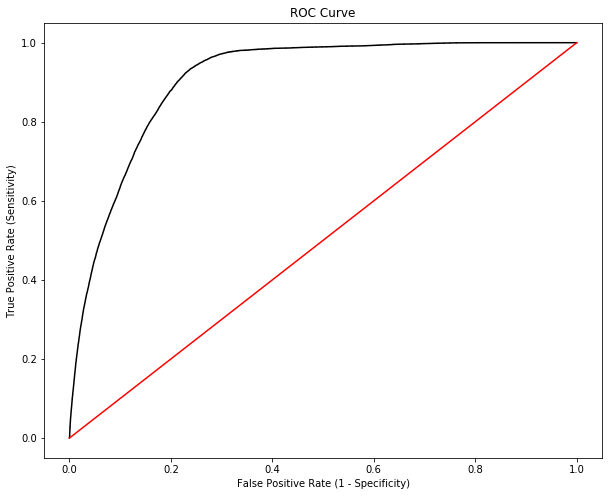

In [27]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [35]:
#predictors
print(len(predictors))
print(len(logistic_clf.coef_[0]))

19
19


In [46]:
coefs = pd.DataFrame([[pred, coef] for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
                     columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
7,meanMaxTemp_Aug,2.368513
2,meanTemp_Aug,-2.337345
10,vegetation,1.572226
17,lat,1.511980
1,meanTemp_AprAug,-0.777255
5,meanMinTemp_Jan,0.776411
16,elev_etopo1,0.668445
0,meanTemp_Annual,0.651356
8,precip_meanAnnual,-0.473947
9,precip_JunAug,-0.466761
